In [ ]:
# =============================
# 1. Install Dependencies
# =============================
!pip install transformers datasets pandas torch --quiet

# =============================
# 2. Imports & Seed Setup
# =============================
import re
import numpy as np
import pandas as pd
import torch
import random
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    default_data_collator,
    EarlyStoppingCallback,
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq
)

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# =============================
# 3. Load & Clean Dataset
# =============================
df = pd.read_csv('/content/drive/MyDrive/NLP/jokes_from_hf.csv')

def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna(subset=['text'])
    df = df.drop_duplicates(subset=['text'])
    df['text'] = df['text'].str.strip()
    df = df[df['text'] != '']
    return df

# Basic cleaning: remove unwanted chars, ensure punctuation
pattern = re.compile(r"[^a-zA-Z0-9\s,.!?'-]")

def clean_text(text: str) -> str:
    text = pattern.sub('', text)
    text = ' '.join(text.split()).strip()
    if text and text[-1] not in {'.', '!', '?'}:
        text += '.'
    return text

# Apply cleaning
df = clean_dataset(df)
df['text'] = df['text'].apply(clean_text)
# Filter short entries
df = df[df['text'].str.split().str.len() > 3]

# =============================
# 4. Split & Create HF Dataset
# =============================
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=seed)
train_dataset = Dataset.from_dict({'text': train_df['text'].tolist()})
eval_dataset  = Dataset.from_dict({'text': eval_df['text'].tolist()})

# =============================
# 5. Load Model & Tokenizer
# =============================
model_name = 'google/flan-t5-small'
tokenizer  =  T5Tokenizer.from_pretrained(model_name)
model      = T5ForConditionalGeneration.from_pretrained(model_name)

#add peft
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)

# Add special tokens
special_tokens = {'bos_token': '[START]', 'eos_token': '[END]'}
tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# =============================
# 6. Determine max_length
# =============================
lengths = [len(tokenizer.encode(j)) + 2 for j in df['text']]
max_length = min(128, int(np.percentile(lengths, 95)))

# =============================
# 7. Preprocessing Function
# =============================
def preprocess_function(examples):
    texts = [f"{tokenizer.bos_token} {j} {tokenizer.eos_token}" for j in examples['text']]
    encodings = tokenizer(
        texts,
        truncation=True,
        max_length=max_length,
        padding='max_length'
    )
    encodings['labels'] = encodings['input_ids'].copy()
    return encodings

# Tokenize datasets
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=['text']
)
tokenized_eval = eval_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=['text']
)

# =============================
# 8. Training Arguments & Trainer
# =============================
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NLP/hasil_jokes_hf',
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    max_grad_norm=1.0,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    logging_steps=500,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    report_to='none',
    torch_compile=True
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding='max_length',
    max_length=max_length
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# =============================
# 9. Train & Save
# =============================
trainer.train()
trainer.save_model(training_args.output_dir)
tokenizer.save_pretrained(training_args.output_dir)
import math

eval_results = trainer.evaluate()
print("Perplexity:", math.exp(eval_results['eval_loss']))



Token indices sequence length is longer than the specified maximum sequence length for this model (1069 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/448851 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: p

Map (num_proc=4):   0%|          | 0/112213 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has [END]. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: p

Epoch,Training Loss,Validation Loss
1,0.000000,nan


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from peft import PeftModel
import torch
import re



BASE_MODEL_NAME = 'google/flan-t5-small'
ADAPTER_PATH = '/content/drive/MyDrive/NLP/hasil_jokes_hf'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = T5Tokenizer.from_pretrained(ADAPTER_PATH, legacy=False)

base_model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_NAME).to(device)

base_model.resize_token_embeddings(len(tokenizer))

model = PeftModel.from_pretrained(base_model, ADAPTER_PATH).to(device)

model.eval()

print("✅ Model berhasil dimuat tanpa error!")

def clean_generated_text(text: str) -> str:
    text = re.sub(r'\[(START|END|PAD)\]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'([,.!?])([A-Za-z])', r'\1 \2', text)
    if '?' in text:
        parts = text.split('?', 1)
        q = parts[0].strip()
        a = parts[1].strip().capitalize() if len(parts) > 1 else ''
        text = f"{q}? {a}"
    return text.strip()

def generate_joke(prompt: str) -> str:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            max_length=80,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            repetition_penalty=1.5
        )

    joke = tokenizer.decode(outputs[0], skip_special_tokens=True)
    joke = joke.replace(prompt, "").strip()
    return clean_generated_text(joke)

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Model berhasil dimuat tanpa error!


In [9]:
# Buat prompt berupa awal lelucon
prompt_awal = "why a dog never be clever?"

hasil_jokes = generate_joke(prompt_awal)
print(f"Lelucon tentang ikan:\n{prompt_awal} {hasil_jokes}")

Lelucon tentang ikan:
why a dog never be clever? politico </s>


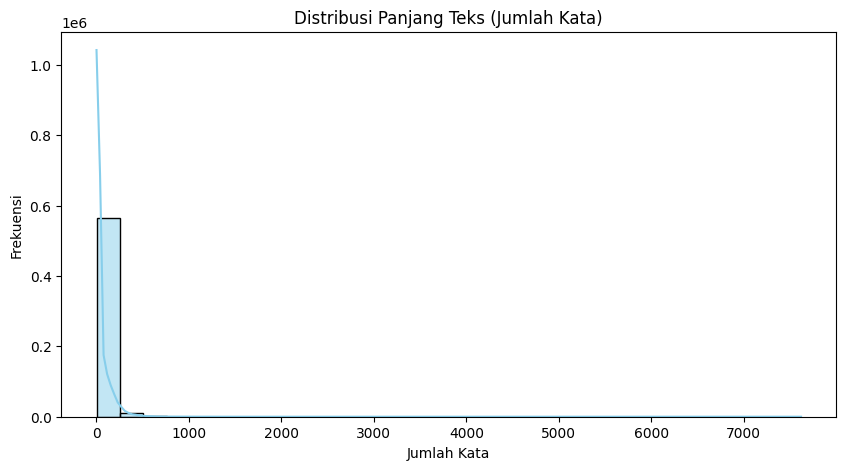

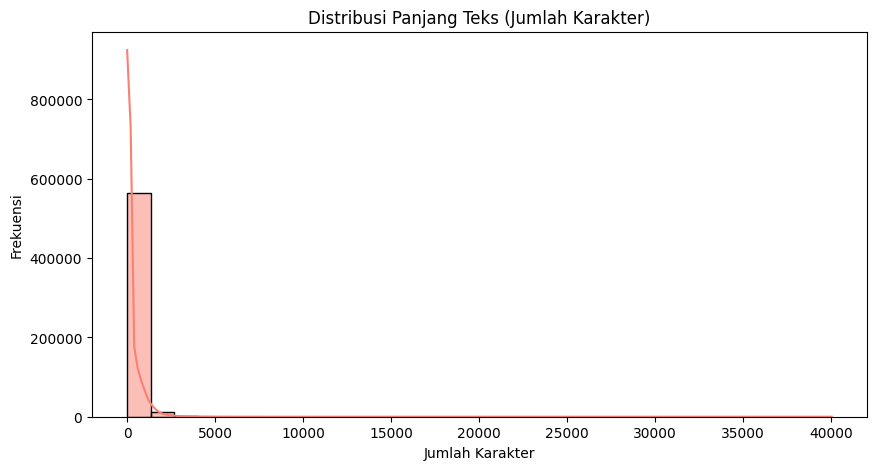

Missing Values per Kolom:
text          4475
word_count       0
char_count       0
dtype: int64

Jumlah jokes unik: 561506


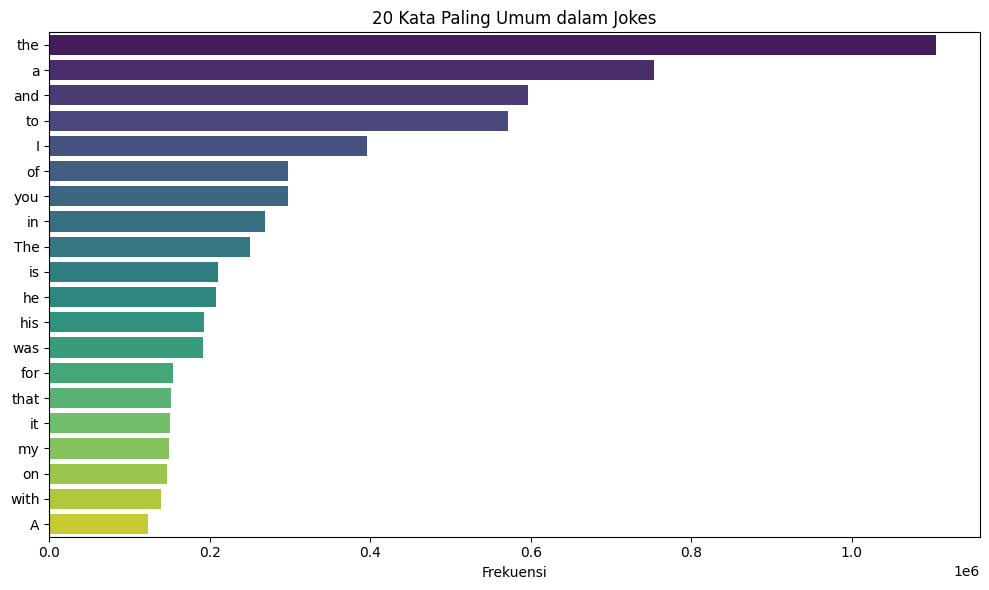

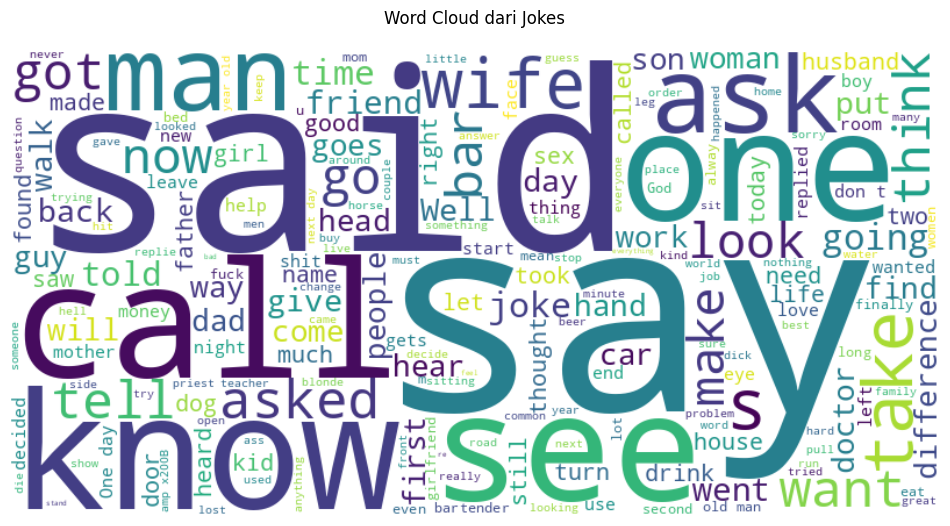


Statistik Deskriptif:
Total jokes: 578634
Rata-rata kata per joke: 41.5
Rata-rata karakter per joke: 222.5
Joke terpendek: 1 kata
Joke terpanjang: 7619 kata


In [10]:
# =============================
# 3A. Exploratory Data Analysis (EDA)
# =============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

df = pd.read_csv('/content/drive/MyDrive/NLP/jokes_from_hf.csv')

# 1. Distribusi panjang teks
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Plot histogram panjang teks (jumlah kata)
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

# Plot histogram panjang teks (jumlah karakter)
plt.figure(figsize=(10, 5))
sns.histplot(df['char_count'], bins=30, kde=True, color='salmon')
plt.title('Distribusi Panjang Teks (Jumlah Karakter)')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

# 2. Cek missing values dan data unik
print("Missing Values per Kolom:")
print(df.isnull().sum())
print(f"\nJumlah jokes unik: {df['text'].nunique()}")

# 3. Analisis kata umum (dalam figure terpisah)
plt.figure(figsize=(10, 6))
all_words = ' '.join(df['text'].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('20 Kata Paling Umum dalam Jokes')
plt.xlabel('Frekuensi')
plt.tight_layout()
plt.show()

# 4. Word cloud (figure terpisah)
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=200).generate(' '.join(df['text'].astype(str)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Jokes', pad=20)
plt.show()

# 5. Statistik deskriptif
print("\nStatistik Deskriptif:")
print(f"Total jokes: {len(df)}")
print(f"Rata-rata kata per joke: {df['word_count'].mean():.1f}")
print(f"Rata-rata karakter per joke: {df['char_count'].mean():.1f}")
print(f"Joke terpendek: {df['word_count'].min()} kata")
print(f"Joke terpanjang: {df['word_count'].max()} kata")

In [12]:
# =============================
# 10. Feature Representation
# =============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from transformers import BertTokenizer, BertModel
import pandas as pd
import torch
import numpy as np

# Load and clean data
df = pd.read_csv('/content/drive/MyDrive/NLP/jokes_from_hf.csv')

# Handle missing values and ensure string type
df['text'] = df['text'].astype(str)  # Convert all to string
df = df[df['text'].str.strip() != '']  # Remove empty strings
df = df.dropna(subset=['text'])  # Remove any remaining NaN values

# ----------------------------
# A. Sparse Representation - TF-IDF
# ----------------------------
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
try:
    X_tfidf = tfidf.fit_transform(df['text'])

    print("\nTF-IDF Results:")
    print("Shape:", X_tfidf.shape)
    print("Feature names (first 10):", tfidf.get_feature_names_out()[:10])
    print("Example vector (first document):")
    print(X_tfidf[0].toarray())  # Using toarray() instead of todense() for better readability

    # Dimensionality reduction with SVD
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_tfidf_reduced = svd.fit_transform(X_tfidf)

    print("\nReduced TF-IDF:")
    print("Shape:", X_tfidf_reduced.shape)
    print("Explained variance ratio (first 10 components):", svd.explained_variance_ratio_[:10])
    print("Example reduced vector (first document):")
    print(X_tfidf_reduced[0][:10])  # Showing first 10 dimensions

except Exception as e:
    print(f"Error in TF-IDF processing: {str(e)}")

# ----------------------------
# B. Dense Representation - BERT Embedding
# ----------------------------
# Use a small subset for demonstration
subset_size = min(3, len(df))  # Ensure we don't exceed available samples
subset_jokes = df['text'].sample(subset_size, random_state=42).tolist()

try:
    print("\nProcessing BERT embeddings for:", subset_jokes)

    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")

    def get_bert_embedding(texts):
        # Tokenize with truncation and padding
        encoded = bert_tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=64
        )

        # Get embeddings
        with torch.no_grad():
            output = bert_model(**encoded)

        # Use mean pooling instead of CLS token for better sentence representation
        embeddings = torch.mean(output.last_hidden_state, dim=1)
        return embeddings

    bert_embeddings = get_bert_embedding(subset_jokes)

    print("\nBERT Embedding Results:")
    print("Shape:", bert_embeddings.shape)
    print("Example vector (first document, first 10 dimensions):")
    print(bert_embeddings[0][:10])  # Showing first 10 dimensions

except Exception as e:
    print(f"Error in BERT processing: {str(e)}")


TF-IDF Results:
Shape: (578634, 3000)
Feature names (first 10): ['00' '000' '10' '100' '1000' '11' '12' '13' '14' '15']
Example vector (first document):
[[0. 0. 0. ... 0. 0. 0.]]

Reduced TF-IDF:
Shape: (578634, 100)
Explained variance ratio (first 10 components): [0.00410888 0.00778725 0.00668961 0.00567573 0.00465741 0.00445814
 0.00414657 0.00388101 0.00371713 0.00347279]
Example reduced vector (first document):
[ 5.53867623e-03 -2.45230134e-06 -1.22013276e-03  3.24452618e-04
 -1.08475984e-03 -1.64416671e-03 -1.06780022e-03 -2.06700178e-04
 -3.92141591e-04  1.27954593e-03]

Processing BERT embeddings for: ['How many Blondes does it take to bake chocolate chip cookies? 10....one to bake the cookies, and 9 to peel the M&amp;Ms', 'Inappropriate times for the Kool-Aid Man to bust through the wall. “I’m so glad you brought me here Jack, I’ve never seen the engine room of an Ocean Liner before.”\n\n“Oh, no?”\n\n**”Oh, Yeah!”**', 'A priest, a Rabbi, and a ghost walk into a bar. The barten

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Error in BERT processing: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5966176d-f333-4789-a674-aea73641d562)')


In [25]:
# =============================
# 1. Install Required Packages with Clean Setup
# =============================
!pip install --upgrade --quiet rouge-score nltk pandas transformers torch

# =============================
# 2. Import Libraries with Robust Initialization
# =============================
import os
import pandas as pd
import torch
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from collections import defaultdict

# =============================
# 3. Complete NLTK Data Setup
# =============================
def setup_nltk():
    try:
        # First try the standard punkt download
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading NLTK punkt data...")
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('punkt_tab', quiet=True)  # Specifically for the tab tokenizer
        except Exception as e:
            print(f"Error downloading NLTK data: {e}")
            # Fallback to manual download if needed
            try:
                import urllib.request
                import shutil
                print("Attempting manual download of punkt data...")
                url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/tokenizers/punkt.zip"
                urllib.request.urlretrieve(url, 'punkt.zip')
                shutil.unpack_archive('punkt.zip', os.path.expanduser('~/nltk_data/tokenizers'))
                os.remove('punkt.zip')
            except Exception as e:
                print(f"Manual download failed: {e}")
                raise

setup_nltk()

# =============================
# 4. Enhanced Data Loading with Validation
# =============================
def load_and_clean_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found at {file_path}")

    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {len(df)} jokes")

        # Enhanced cleaning
        def clean_text(text):
            text = str(text).strip()
            if not text:
                return ""
            if text[-1] not in {'.', '!', '?'}:
                text += '.'
            return text

        df = df.dropna(subset=['text'])
        df['text'] = df['text'].apply(clean_text)
        df = df[df['text'] != '']

        print(f"After cleaning: {len(df)} jokes remaining")
        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load dataset with error handling
try:
    data_path = '/content/drive/MyDrive/NLP/jokes_from_hf.csv'
    df = load_and_clean_data(data_path)

    # Create evaluation split with size validation
    eval_size = min(50, max(10, int(len(df) * 0.2)))  # Ensure reasonable sample size
    eval_df = df.sample(n=eval_size, random_state=42)
    print(f"Created evaluation set with {len(eval_df)} samples")

except Exception as e:
    print(f"Data loading failed: {e}")
    raise

# =============================
# 5. Robust Model Evaluation Function
# =============================
def evaluate_jokes_model(model_path, eval_df, num_samples=50):
    # Validate inputs
    if not isinstance(eval_df, pd.DataFrame) or 'text' not in eval_df.columns:
        raise ValueError("eval_df must be a DataFrame with 'text' column")

    num_samples = min(num_samples, len(eval_df))
    print(f"\nEvaluating on {num_samples} samples...")

    # Load tokenizer with enhanced error handling
    try:
        print("Loading tokenizer...")
        tokenizer = T5Tokenizer.from_pretrained(
            model_path,
            bos_token='[START]',
            eos_token='[END]'
        )
        print("Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None

    # Load model with comprehensive error handling
    try:
        print("Loading model...")
        model = T5ForConditionalGeneration.from_pretrained(
            model_path,
            vocab_size=len(tokenizer),
            ignore_mismatched_sizes=True
        )
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = model.to(device)
        print(f"Model loaded on {device}")
    except Exception as e:
        print(f"Model loading failed: {e}")
        return None

    # Joke generation with improved parameters
    def generate_jokes(prompts, max_length=128):
        inputs = tokenizer(
            [f"{tokenizer.bos_token} {p} {tokenizer.eos_token}" for p in prompts],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(device)

        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_beams=5,
            early_stopping=True,
            temperature=0.7,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            repetition_penalty=1.2
        )
        return [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]

    # Generate jokes with progress feedback
    print("Generating jokes...")
    test_samples = eval_df['text'].sample(num_samples, random_state=42).tolist()
    generated_jokes = generate_jokes(test_samples)
    print("Generation complete")

    # Evaluation metrics with comprehensive error handling
    metrics = {'bleu': None, 'rouge': None}

    # BLEU Score Calculation
    try:
        print("Calculating BLEU score...")
        references = [[nltk.word_tokenize(ref.lower())] for ref in test_samples]
        hypotheses = [nltk.word_tokenize(hyp.lower()) for hyp in generated_jokes]
        smoothing = SmoothingFunction().method4
        metrics['bleu'] = corpus_bleu(references, hypotheses, smoothing_function=smoothing)
        print(f"BLEU score calculated: {metrics['bleu']:.4f}")
    except Exception as e:
        print(f"BLEU calculation failed: {e}")

    # ROUGE Score Calculation
    try:
        print("Calculating ROUGE scores...")
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = defaultdict(lambda: {'f': 0, 'p': 0, 'r': 0})

        for ref, hyp in zip(test_samples, generated_jokes):
            scores = scorer.score(ref, hyp)
            for key in scores:
                rouge_scores[key]['f'] += scores[key].fmeasure
                rouge_scores[key]['p'] += scores[key].precision
                rouge_scores[key]['r'] += scores[key].recall

        for key in rouge_scores:
            for metric in ['f', 'p', 'r']:
                rouge_scores[key][metric] /= len(test_samples)

        metrics['rouge'] = dict(rouge_scores)
        print("ROUGE scores calculated")
    except Exception as e:
        print(f"ROUGE calculation failed: {e}")

    return {
        'metrics': metrics,
        'examples': list(zip(test_samples, generated_jokes)),
        'model_info': {
            'device': device,
            'vocab_size': len(tokenizer),
            'num_parameters': sum(p.numel() for p in model.parameters())
        }
    }

# =============================
# 6. Run Evaluation with Comprehensive Error Handling
# =============================
try:
    model_path = '/content/drive/MyDrive/NLP/hasil_jokes_hf'
    print(f"\nStarting evaluation with model from {model_path}")

    results = evaluate_jokes_model(model_path, eval_df)

    # =============================
    # 7. Enhanced Results Display
    # =============================
    if results:
        print("\n=== FINAL EVALUATION RESULTS ===")

        # Metrics Summary
        print("\n--- Quantitative Metrics ---")
        if results['metrics']['bleu'] is not None:
            print(f"BLEU Score: {results['metrics']['bleu']:.4f}")
        else:
            print("BLEU Score: Not available")

        if results['metrics']['rouge']:
            print("\nROUGE Scores:")
            for metric, scores in results['metrics']['rouge'].items():
                print(f"{metric.upper():<7} F1: {scores['f']:.4f}  Precision: {scores['p']:.4f}  Recall: {scores['r']:.4f}")
        else:
            print("\nROUGE Scores: Not available")

        # Model Info
        print("\n--- Model Information ---")
        print(f"Device used: {results['model_info']['device']}")
        print(f"Vocabulary size: {results['model_info']['vocab_size']}")
        print(f"Total parameters: {results['model_info']['num_parameters']:,}")

        # Qualitative Examples
        print("\n--- Qualitative Examples ---")
        for i, (original, generated) in enumerate(results['examples'][:5]):
            print(f"\nEXAMPLE {i+1}:")
            print(f"Original:\n{original}")
            print(f"\nGenerated:\n{generated}")
            print("-" * 80)
    else:
        print("\nEvaluation failed - no results returned")

except Exception as e:
    print(f"\nEVALUATION FAILED: {e}")
    raise

Successfully loaded 578634 jokes
After cleaning: 574159 jokes remaining
Created evaluation set with 50 samples

Starting evaluation with model from /content/drive/MyDrive/NLP/hasil_jokes_hf

Evaluating on 50 samples...
Loading tokenizer...
Tokenizer loaded successfully
Loading model...


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized because the shapes did not match:
- lm_head.weight: found shape torch.Size([32128, 512]) in the checkpoint and torch.Size([32102, 512]) in the model instantiated
- shared.weight: found shape torch.Size([32128, 512]) in the checkpoint and torch.Size([32102, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda
Generating jokes...
Generation complete
Calculating BLEU score...
BLEU calculation failed: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Calculating ROUGE scores...
ROUGE scores calculated

=== FINAL EVALUATION RESULTS ===

--- Quantitative Metrics ---
BLEU Score: Not available

ROUGE Scores:
ROUGE1  F1: 0.1348  Precision: 0.1064  Recall: 0.3347
ROUGE2  F1: 0.1121  Precision: 0.086